# pyiron_workflow
## Define workflow with pyiron_base

In [1]:
from inspect import isfunction
import numpy as np
from pyiron_workflow import Workflow, to_function_node, as_function_node
from pyiron_workflow.api import inputs_to_dict
from python_workflow_definition.pyiron_workflow import write_workflow_json

In [3]:
from workflow import (
    calculate_qe as _calculate_qe, 
    generate_structures as _generate_structures, 
    get_bulk_structure as _get_bulk_structure, 
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [4]:
@as_function_node("output_dict")
def get_values_from_dict(input_dict):
    return list(input_dict.values())

In [5]:
workflow_json_filename = "pyiron_workflow_qe.json"

In [6]:
calculate_qe = to_function_node("calculate_qe", _calculate_qe, "calculate_qe")
generate_structures = to_function_node("generate_structures", _generate_structures, "generate_structures")
get_bulk_structure = to_function_node("get_bulk_structure", _get_bulk_structure, "get_bulk_structure")
plot_energy_volume_curve = to_function_node("plot_energy_volume_curve", _plot_energy_volume_curve, "plot_energy_volume_curve", validate_output_labels=False)

In [7]:
wf = Workflow("my_workflow")

In [8]:
wf.pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [9]:
wf.element = "Al"
wf.a = 4.04
wf.cubic = True
wf.structure = get_bulk_structure(
    element=wf.element,
    a=wf.a,
    cubic=wf.cubic,
)

In [10]:
wf.working_directory_0 = "mini"
input_dict = {
    "structure": wf.structure, 
    "pseudopotentials": wf.pseudopotentials, 
    "kpts": (3, 3, 3), 
    "calculation": "vc-relax", 
    "smearing": 0.02,
}
wf.input_dict_0 = inputs_to_dict(
    input_specification=list(input_dict.keys()),
    **input_dict
)

In [11]:
wf.calc_mini = calculate_qe(
    working_directory=wf.working_directory_0,
    input_dict=wf.input_dict_0,
)

In [12]:
number_of_strains = 5
wf.strain_lst = np.linspace(0.9, 1.1, number_of_strains)
wf.structure_lst = generate_structures(  # the generate_structures() function is not available in the workflow graph
    structure=wf.calc_mini["structure"],
    strain_lst=wf.strain_lst,
)

In [13]:
job_strain_lst = []
for i in range(number_of_strains):
    setattr(wf, "input_dict_" + str(i+1), inputs_to_dict(
        input_specification=["structure", "pseudopotentials", "kpts", "calculation", "smearing"],
        structure=wf.structure_lst["s_" + str(i)],
        pseudopotentials=wf.pseudopotentials,
        kpts=(3, 3, 3),
        calculation="scf",
        smearing=0.02,
    ))
    setattr(wf, "calc_strain_" + str(i), calculate_qe(
        working_directory="strain_" + str(i),
        input_dict=getattr(wf, "input_dict_" + str(i+1)),
    ))
    job_strain_lst.append(getattr(wf, "calc_strain_" + str(i)))

In [14]:
volume_dict = {"s_" + str(i): j["volume"] for i, j in enumerate(job_strain_lst)}
wf.volume_dict = inputs_to_dict(
    input_specification=list(volume_dict.keys()),
    **volume_dict
)
energy_dict = {"s_" + str(i): j["energy"] for i, j in enumerate(job_strain_lst)}
wf.energy_dict = inputs_to_dict(
    input_specification=list(energy_dict.keys()),
    **energy_dict,
)
wf.volume_lst = get_values_from_dict(
    input_dict=wf.volume_dict
)
wf.energy_lst = get_values_from_dict(
    input_dict=wf.energy_dict
)

In [15]:
wf.plot = plot_energy_volume_curve(volume_lst=wf.volume_lst, energy_lst=wf.energy_lst)

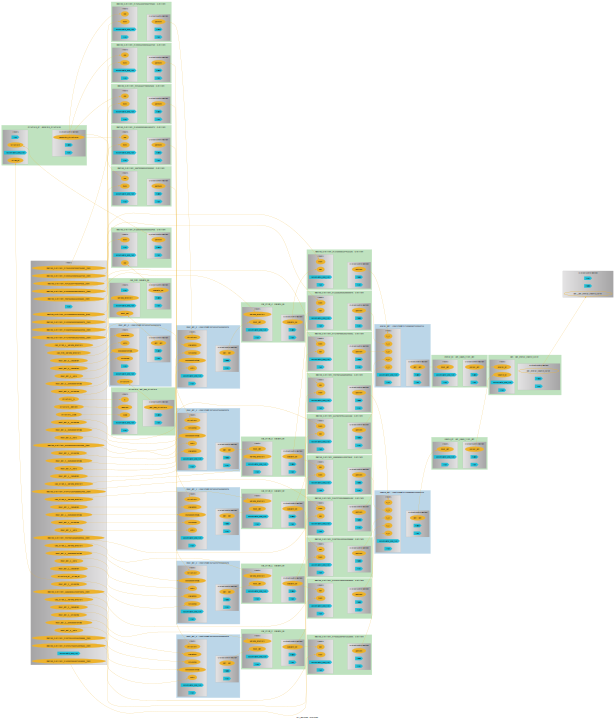

In [16]:
wf.draw(size=(10,10))

In [ ]:
write_workflow_json(graph_as_dict=wf.graph_as_dict, file_name=workflow_json_filename)

In [ ]:
!cat {workflow_json_filename}

## Load Workflow with aiida

In [ ]:
from aiida import orm, load_profile

load_profile()

In [ ]:
from python_workflow_definition.aiida import load_workflow_json

In [ ]:
wg = load_workflow_json(file_name=workflow_json_filename)

In [ ]:
wg.run()

## Load Workflow with jobflow

In [ ]:
from python_workflow_definition.jobflow import load_workflow_json

In [ ]:
from jobflow.managers.local import run_locally

In [ ]:
flow = load_workflow_json(file_name=workflow_json_filename)

In [ ]:
result = run_locally(flow)
result

## Load Workflow with pyiron_base

In [ ]:
from python_workflow_definition.pyiron_base import load_workflow_json

In [ ]:
delayed_object_lst = load_workflow_json(file_name="workflow.json")
delayed_object_lst[-1].draw()

In [ ]:
delayed_object_lst[-1].pull()